In [1]:
sgd = '../out/SGD_features.tab'
dev2 = '../out/deviating_strain_rev.tsv'
dev3 = '../out/deviating_rev_mutants.tsv'

In [2]:
%matplotlib inline

import seaborn as sns
from matplotlib import colors as mplcolors
import matplotlib.pyplot as plt

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
rgn = g[g[1] == 'ORF'].set_index(4)[3].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [5]:
d2 = pd.read_csv(dev2, sep='\t')
d2['name'] = [gn.get(x, x) for x in d2['gene']]

In [6]:
c = d2.reset_index().groupby(['strain1', 'strain2', 'gene', 'condition'])['position'].count()
d2 = d2[d2['position'].str.contains('OLD')].copy()
d2 = d2.reset_index().set_index(['strain1', 'strain2', 'gene', 'condition']).loc[c[c > 1].index].copy()
d2 = d2.sort_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


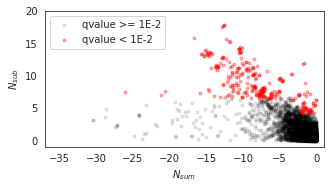

In [7]:
plt.figure(figsize=(5, 2.5))

plt.plot(d2[d2['qval'] >= 0.01]['sum'],
         d2[d2['qval'] >= 0.01]['sub'],
         'k.',
         alpha=0.1,
         label='qvalue >= 1E-2',
         rasterized=True)
plt.plot(d2[d2['qval'] < 0.01]['sum'],
         d2[d2['qval'] < 0.01]['sub'],
         'r.',
         alpha=0.3,
         label='qvalue < 1E-2',
         rasterized=True)

plt.xlabel('$N_{sum}$')
plt.ylabel('$N_{sub}$')

plt.legend(loc='upper left')

plt.xlim(-37, 1)
plt.ylim(-1, 20);

In [8]:
d2 = d2.reset_index().set_index(['strain1', 'strain2', 'gene']).sort_index()
res = []
for x in set(d2.index):
    t = d2.loc[x]
    for p1, p2 in itertools.combinations(t['position'].unique(), 2):
        t1 = t[t['position'] == p1].copy().reset_index().set_index(['strain1', 'strain2', 'gene', 'condition']).sort_index()
        t2 = t[t['position'] == p2].copy().reset_index().set_index(['strain1', 'strain2', 'gene', 'condition']).sort_index()
        w = t1[['position', 'qvalue', 'phenotype1']].join(t2[['position', 'qvalue', 'phenotype2']],
                                            how='inner',
                                            lsuffix='1',
                                            rsuffix='2')
        res.append(w)
w = pd.concat(res)

In [9]:
w['change1'] = w['qvalue1'] < 0.01
w['change2'] = w['qvalue2'] < 0.01

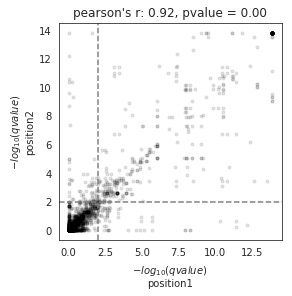

In [10]:
plt.figure(figsize=(4, 4))

minv = sorted(set(w[['qvalue1', 'qvalue2']].values.flatten()))[1]

plt.plot(-np.log10(w['qvalue1'] + minv),
         -np.log10(w['qvalue2'] + minv),
         'k.',
         alpha=0.1,
         rasterized=True)

plt.axhline(-np.log10(0.01 + minv),
            color='grey',
            ls='dashed')
plt.axvline(-np.log10(0.01 + minv),
            color='grey',
            ls='dashed')

plt.xlabel('$-log_{10}(qvalue)$\nposition1')
plt.ylabel('$-log_{10}(qvalue)$\nposition2')

plt.title('pearson\'s r: %.2f, pvalue = %.2f' % stats.pearsonr(-np.log10(w['qvalue1'] + minv),
                                                               -np.log10(w['qvalue2'] + minv)))

plt.savefig('deviations_reproducibility_all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_reproducibility_all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


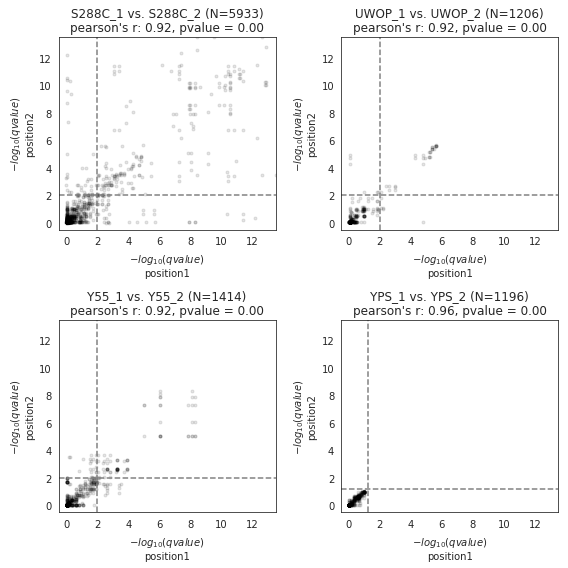

In [11]:
plt.figure(figsize=(8, 8))

i = 1
for s1, s2 in {(x[0], x[1]) for x in w.index}:
    plt.subplot(2, 2, i)
    t = w.loc[(s1, s2),]
    
    minv = sorted(set(t[['qvalue1', 'qvalue2']].values.flatten()))[1]

    plt.plot(-np.log10(t['qvalue1'] + minv),
             -np.log10(t['qvalue2'] + minv),
             'k.',
             alpha=0.1)

    plt.axhline(-np.log10(0.01 + minv),
                color='grey',
                ls='dashed')
    plt.axvline(-np.log10(0.01 + minv),
                color='grey',
                ls='dashed')

    plt.xlabel('$-log_{10}(qvalue)$\nposition1')
    plt.ylabel('$-log_{10}(qvalue)$\nposition2')
    
    plt.title(s1 + ' vs. ' + s2 + ' (N=%d)' % t.shape[0] +
              '\npearson\'s r: %.2f, pvalue = %.2f' % stats.pearsonr(-np.log10(t['qvalue1'] + minv),
                                                                     -np.log10(t['qvalue2'] + minv)))
    
    i += 1
    plt.xlim(-0.5, 13.5)
    plt.ylim(-0.5, 13.5)

plt.tight_layout()

plt.savefig('deviations_reproducibility.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_reproducibility.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [12]:
res = []
threshold1 = 0.01
for threshold in [1E-10, 1E-8, 1E-6, 1E-4, 1E-2, 0.05]:
    w['change1'] = w['qvalue1'] < threshold
    w['change2'] = w['qvalue2'] < threshold1
    a = w.shape[0]
    v = w[(w['change1'] != w['change2'])].shape[0]
    p = v / w.shape[0]
    res.append((threshold, a, v, p))
r = pd.DataFrame(res,
                 columns=['threshold', 'deviations', 'variable', 'proportion'])

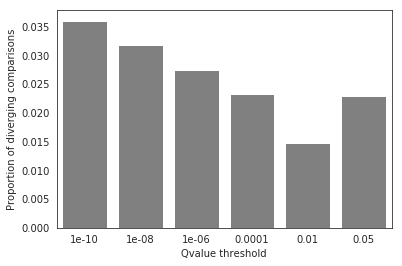

In [13]:
sns.barplot(data=r,
            x='threshold',
            y='proportion',
            orient='v',
            color='grey')
plt.xlabel('Qvalue threshold')
plt.ylabel('Proportion of diverging comparisons')
plt.savefig('deviations_reproducibility_barplot_all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_reproducibility_barplot_all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [14]:
res = []
threshold1 = 0.01
for threshold in [1E-10, 1E-8, 1E-6, 1E-4, 1E-2, 0.05]:
    w['change1'] = w['qvalue1'] < threshold
    w['change2'] = w['qvalue2'] < threshold1
    a = w[(w['qvalue1'] < threshold)].shape[0]
    v = w[(w['qvalue1'] < threshold) & (w['change1'] != w['change2'])].shape[0]
    p = v / w[(w['qvalue1'] < threshold)].shape[0]
    res.append((threshold, a, v, p))
r = pd.DataFrame(res,
                 columns=['threshold', 'deviations', 'variable', 'proportion'])

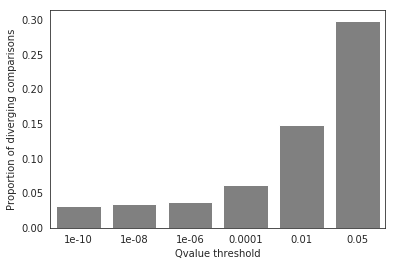

In [15]:
sns.barplot(data=r,
            x='threshold',
            y='proportion',
            orient='v',
            color='grey')
plt.xlabel('Qvalue threshold')
plt.ylabel('Proportion of diverging comparisons')
plt.savefig('deviations_reproducibility_barplot.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_reproducibility_barplot.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [16]:
d2 = pd.read_csv(dev3, sep='\t')
d2['name'] = [gn.get(x, x) for x in d2['gene']]

In [17]:
c = d2.reset_index().groupby(['strain1', 'strain2', 'gene', 'condition'])['position'].count()
d2 = d2.reset_index().set_index(['strain1', 'strain2', 'gene', 'condition']).loc[c[c > 1].index].copy()
d2 = d2.sort_index()

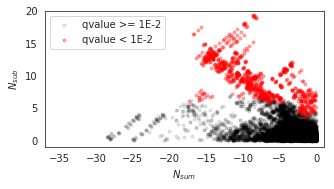

In [18]:
plt.figure(figsize=(5, 2.5))

plt.plot(d2[d2['qval'] >= 0.01]['sum'],
         d2[d2['qval'] >= 0.01]['sub'],
         'k.',
         alpha=0.1,
         label='qvalue >= 1E-2',
         rasterized=True)
plt.plot(d2[d2['qval'] < 0.01]['sum'],
         d2[d2['qval'] < 0.01]['sub'],
         'r.',
         alpha=0.3,
         label='qvalue < 1E-2',
         rasterized=True)

plt.xlabel('$N_{sum}$')
plt.ylabel('$N_{sub}$')

plt.legend(loc='upper left')

plt.xlim(-37, 1)
plt.ylim(-1, 20);

In [19]:
d2 = d2.reset_index().set_index(['strain1', 'strain2', 'gene']).sort_index()
res = []
for x in set(d2.index):
    t = d2.loc[x]
    for p1, p2 in itertools.combinations(t['position'].unique(), 2):
        t1 = t[t['position'] == p1].copy().reset_index().set_index(['strain1', 'strain2', 'gene', 'condition']).sort_index()
        t2 = t[t['position'] == p2].copy().reset_index().set_index(['strain1', 'strain2', 'gene', 'condition']).sort_index()
        w = t1[['position', 'qvalue', 'phenotype1']].join(t2[['position', 'qvalue', 'phenotype2']],
                                            how='inner',
                                            lsuffix='1',
                                            rsuffix='2')
        res.append(w)
w = pd.concat(res)

In [20]:
w['change1'] = w['qvalue1'] < 0.01
w['change2'] = w['qvalue2'] < 0.01

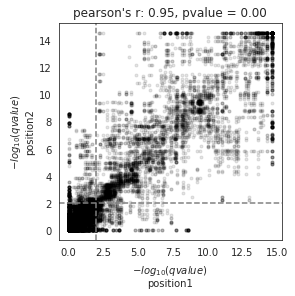

In [21]:
plt.figure(figsize=(4, 4))

minv = sorted(set(w[['qvalue1', 'qvalue2']].values.flatten()))[1]

plt.plot(-np.log10(w['qvalue1'] + minv),
         -np.log10(w['qvalue2'] + minv),
         'k.',
         alpha=0.1,
         rasterized=True)

plt.axhline(-np.log10(0.01 + minv),
            color='grey',
            ls='dashed')
plt.axvline(-np.log10(0.01 + minv),
            color='grey',
            ls='dashed')

plt.xlabel('$-log_{10}(qvalue)$\nposition1')
plt.ylabel('$-log_{10}(qvalue)$\nposition2')

plt.title('pearson\'s r: %.2f, pvalue = %.2f' % stats.pearsonr(-np.log10(w['qvalue1'] + minv),
                                                               -np.log10(w['qvalue2'] + minv)))

plt.savefig('deviations_reproducibility_rev_all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_reproducibility_rev_all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

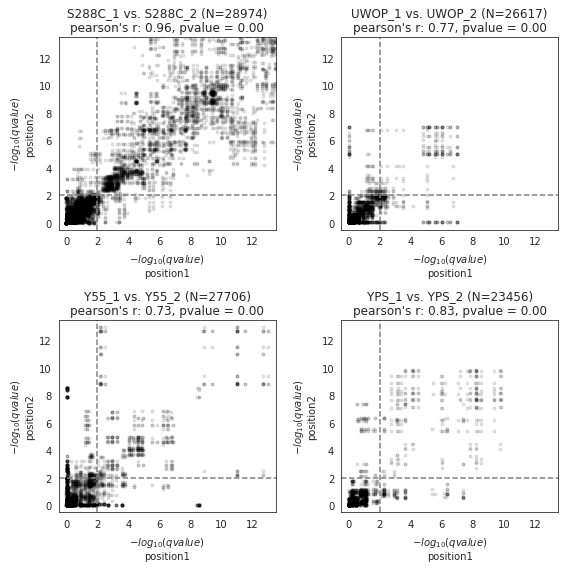

In [22]:
plt.figure(figsize=(8, 8))

i = 1
for s1, s2 in {(x[0], x[1]) for x in w.index}:
    plt.subplot(2, 2, i)
    t = w.loc[(s1, s2),]
    
    minv = sorted(set(t[['qvalue1', 'qvalue2']].values.flatten()))[1]

    plt.plot(-np.log10(t['qvalue1'] + minv),
             -np.log10(t['qvalue2'] + minv),
             'k.',
             alpha=0.1)

    plt.axhline(-np.log10(0.01 + minv),
                color='grey',
                ls='dashed')
    plt.axvline(-np.log10(0.01 + minv),
                color='grey',
                ls='dashed')

    plt.xlabel('$-log_{10}(qvalue)$\nposition1')
    plt.ylabel('$-log_{10}(qvalue)$\nposition2')
    
    plt.title(s1 + ' vs. ' + s2 + ' (N=%d)' % t.shape[0] +
              '\npearson\'s r: %.2f, pvalue = %.2f' % stats.pearsonr(-np.log10(t['qvalue1'] + minv),
                                                                     -np.log10(t['qvalue2'] + minv)))
    
    i += 1
    plt.xlim(-0.5, 13.5)
    plt.ylim(-0.5, 13.5)

plt.tight_layout()

plt.savefig('deviations_reproducibility_rev.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_reproducibility_rev.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [23]:
res = []
threshold1 = 0.01
for threshold in [1E-10, 1E-8, 1E-6, 1E-4, 1E-2, 0.05]:
    w['change1'] = w['qvalue1'] < threshold
    w['change2'] = w['qvalue2'] < threshold1
    a = w.shape[0]
    v = w[(w['change1'] != w['change2'])].shape[0]
    p = v / w.shape[0]
    res.append((threshold, a, v, p))
r = pd.DataFrame(res,
                 columns=['threshold', 'deviations', 'variable', 'proportion'])

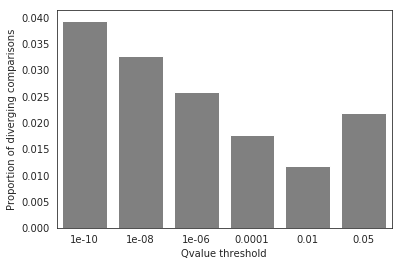

In [24]:
sns.barplot(data=r,
            x='threshold',
            y='proportion',
            orient='v',
            color='grey')
plt.xlabel('Qvalue threshold')
plt.ylabel('Proportion of diverging comparisons')
plt.savefig('deviations_reproducibility_barplot_rev_all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_reproducibility_barplot_rev_all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [25]:
res = []
threshold1 = 0.01
for threshold in [1E-10, 1E-8, 1E-6, 1E-4, 1E-2, 0.05]:
    w['change1'] = w['qvalue1'] < threshold
    w['change2'] = w['qvalue2'] < threshold1
    a = w[(w['qvalue1'] < threshold)].shape[0]
    v = w[(w['qvalue1'] < threshold) & (w['change1'] != w['change2'])].shape[0]
    p = v / w[(w['qvalue1'] < threshold)].shape[0]
    res.append((threshold, a, v, p))
r = pd.DataFrame(res,
                 columns=['threshold', 'deviations', 'variable', 'proportion'])

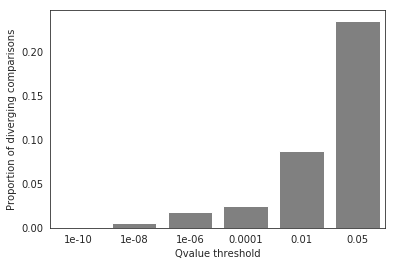

In [26]:
sns.barplot(data=r,
            x='threshold',
            y='proportion',
            orient='v',
            color='grey')
plt.xlabel('Qvalue threshold')
plt.ylabel('Proportion of diverging comparisons')
plt.savefig('deviations_reproducibility_rev_barplot.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_reproducibility_rev_barplot.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);